# Notebook to try out Stochastic Gradient Descent

In [1]:
%matplotlib inline
from fastai import *

#### Number of training examples: n

In [2]:
n=100

#### To simulate bias, we includes a column of ones for each input value. So the input tensor has the actual x value and a 1.0

In [3]:
x = torch.ones(n, 2)
x.shape

torch.Size([100, 2])

#### Set the x value to a random number in [-1, 1]

In [4]:
x[:,0].uniform_(-1, 1)
x[:5]

tensor([[ 0.8833,  1.0000],
        [-0.5769,  1.0000],
        [-0.1892,  1.0000],
        [ 0.5717,  1.0000],
        [ 0.7182,  1.0000]])

#### a is the parameter tensor. it has two parts. first part is the actual weight and second part is the bias which makes this model an affine transformation. Something like a[0] * x + a[1]

In [5]:
a = tensor(3.,2); a

tensor([3., 2.])

In [6]:
x.shape, a.shape

(torch.Size([100, 2]), torch.Size([2]))

#### @ operator does a matrix multiply of the input and the parameters (only weight part) and gives the output

In [7]:
x@a

tensor([ 4.6500,  0.2692,  1.4325,  3.7150,  4.1545,  3.5699,  2.2916, -0.7714,
         3.1969,  0.1706,  2.1427,  1.2778,  0.9062,  3.7316,  1.9353,  1.5777,
         1.7149,  1.3578,  1.4210,  3.5520, -0.1473,  2.3666,  2.2614,  0.5830,
        -0.1287,  1.6576,  2.4325,  0.4162,  2.7627,  1.9891, -0.5747,  3.1047,
         2.2536,  1.2823,  0.1682,  1.7521,  3.6567,  4.1403,  2.8422,  0.8144,
         1.0899,  1.4085, -0.3624,  0.4817,  2.8488,  1.9306, -0.0050,  1.9470,
         2.2610, -0.7341,  1.8245,  0.3485, -0.9508,  0.3846,  0.8150,  4.6338,
         4.7591,  1.8832, -0.3918,  3.4717, -0.5389,  4.9088,  2.1165,  2.9692,
         3.1935,  0.6109,  0.9293,  1.1738,  1.4100,  1.9791, -0.4606, -0.7903,
         2.1799,  1.2946,  0.0697,  1.7323,  4.3526,  2.2349,  3.3775,  3.1255,
         1.9078,  3.1418,  4.3042,  3.9447,  4.7573, -0.0371,  3.5696, -0.6421,
         4.4563,  3.7175,  0.4889,  2.8020,  1.2254,  4.1977, -0.3475,  4.9173,
         0.6612,  3.5571,  2.9769,  0.23

#### Add some noise when generating the expected output. we expect the model to ignore the noise and learn the underlying distribution

In [8]:
y = x@a + torch.rand(n) 

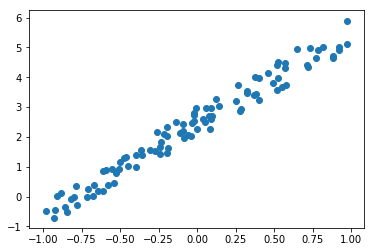

In [9]:
plt.scatter(x[:, 0], y)

#### Loss function is mean squared error

In [10]:
def mse(actual, expected): return ((actual - expected) ** 2).mean()

#### If we pick a certain set of params and check we can find the error and the predictions

In [11]:
a = tensor(-1., 3)
actual = x@a
mse(actual, y)

tensor(5.1676)

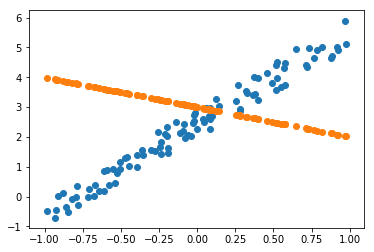

In [12]:
plt.scatter(x[:,0], y)
plt.scatter(x[:,0], actual)

#### Optimization algorithm

In [13]:
a = nn.Parameter(a); a

Parameter containing:
tensor([-1.,  3.], requires_grad=True)

In [14]:
def update():
    actual = x@a
    loss = mse(actual, y)
    if t % 10 == 0: print(loss)
    loss.backward()
    with torch.no_grad():
        a.sub_(lr * a.grad)
        a.grad.zero_()

In [15]:
lr = 1e-1
for t in range(100): update()

tensor(5.1676, grad_fn=<MeanBackward0>)
tensor(1.5036, grad_fn=<MeanBackward0>)
tensor(0.5255, grad_fn=<MeanBackward0>)
tensor(0.2219, grad_fn=<MeanBackward0>)
tensor(0.1271, grad_fn=<MeanBackward0>)
tensor(0.0975, grad_fn=<MeanBackward0>)
tensor(0.0882, grad_fn=<MeanBackward0>)
tensor(0.0853, grad_fn=<MeanBackward0>)
tensor(0.0844, grad_fn=<MeanBackward0>)
tensor(0.0842, grad_fn=<MeanBackward0>)


#### We see that the discovered params are very close to the actual params of the underlying data

In [16]:
a

Parameter containing:
tensor([3.0216, 2.4528], requires_grad=True)

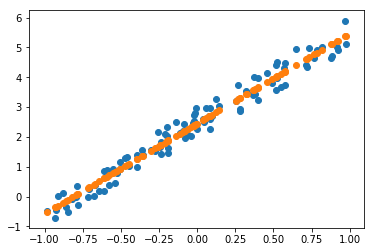

In [17]:
plt.scatter(x[:,0], y)
plt.scatter(x[:,0], x@a)

#### Let us try out weight decay

In [26]:
a = nn.Parameter(tensor(-1, 3.))
def update():
    actual = x@a
    w2 = a[0]**2 + a[1]**2
    loss = mse(actual, y) + wd * w2
    if t % 10 == 0: print(loss)
    loss.backward()
    with torch.no_grad():
        a.sub_(lr * a.grad)
        a.grad.zero_()

lr = 1e-1
wd = 1e-5
for t in range(100): update()

tensor(5.1677, grad_fn=<AddBackward0>)
tensor(1.5037, grad_fn=<AddBackward0>)
tensor(0.5256, grad_fn=<AddBackward0>)
tensor(0.2220, grad_fn=<AddBackward0>)
tensor(0.1272, grad_fn=<AddBackward0>)
tensor(0.0976, grad_fn=<AddBackward0>)
tensor(0.0884, grad_fn=<AddBackward0>)
tensor(0.0855, grad_fn=<AddBackward0>)
tensor(0.0846, grad_fn=<AddBackward0>)
tensor(0.0843, grad_fn=<AddBackward0>)


#### Let us try momentum

In [52]:
a = nn.Parameter(tensor(-1, 3.))
a_previous_grad = 0.

def update(a_previous_grad):
    actual = x@a
    w2 = a[0]**2 + a[1]**2
    loss = mse(actual, y) + wd * w2
    if t % 10 == 0: print(loss)
    loss.backward()
    with torch.no_grad():
        grad = alpha * a.grad + (1-alpha) * a_previous_grad
        a_previous_grad = a.grad
        a.sub_(lr * grad)
        a.grad.zero_()
    return a_previous_grad

lr = 1e-1
wd = 1e-5
alpha = 0.9
for t in range(100):
    a_previous_grad = update(a_previous_grad)

tensor(5.1677, grad_fn=<AddBackward0>)
tensor(1.5210, grad_fn=<AddBackward0>)
tensor(0.5309, grad_fn=<AddBackward0>)
tensor(0.2237, grad_fn=<AddBackward0>)
tensor(0.1277, grad_fn=<AddBackward0>)
tensor(0.0978, grad_fn=<AddBackward0>)
tensor(0.0884, grad_fn=<AddBackward0>)
tensor(0.0855, grad_fn=<AddBackward0>)
tensor(0.0846, grad_fn=<AddBackward0>)
tensor(0.0843, grad_fn=<AddBackward0>)


#### Let us try RMSProp

In [46]:
a = nn.Parameter(tensor(-1, 3.))
a_previous_grad_squared = 0.

def update(a_previous_grad_squared):
    actual = x@a
    w2 = a[0]**2 + a[1]**2
    loss = mse(actual, y) + wd * w2
    if t % 10 == 0: print(loss)
    loss.backward()
    with torch.no_grad():
        a_previous_grad_squared = alpha * a.grad * a.grad + (1-alpha) * a_previous_grad_squared
        a.sub_(lr * a.grad / a_previous_grad_squared)
        a.grad.zero_()
    return a_previous_grad_squared

lr = 1e-1
wd = 1e-5
alpha = 0.1
for t in range(100):
    a_previous_grad_squared = update(a_previous_grad_squared) 

tensor(5.1677, grad_fn=<AddBackward0>)
tensor(1.9139, grad_fn=<AddBackward0>)
tensor(1.0643, grad_fn=<AddBackward0>)
tensor(0.5135, grad_fn=<AddBackward0>)
tensor(0.1971, grad_fn=<AddBackward0>)
tensor(0.1150, grad_fn=<AddBackward0>)
tensor(0.1105, grad_fn=<AddBackward0>)
tensor(0.1262, grad_fn=<AddBackward0>)
tensor(0.1346, grad_fn=<AddBackward0>)
tensor(0.1376, grad_fn=<AddBackward0>)
